## 데이터 전처리

In [1]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

Using TensorFlow backend.


In [30]:
# img_dir = './binary_img_data/imgs'
img_dir = './dataset'
categories = ['Cat', 'Hedgehog']
np_classes = len(categories)

image_w = 64
image_h = 64

pixel = image_h * image_w

X = []
y = []

for idx, cat in enumerate(categories):
    img_dir_detail = img_dir + '/' + cat
    files = glob.glob(img_dir_detail + '/*.jpeg')
    
    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert('RGB')
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            X.append(data)
            y.append(idx)
            if i % 20 == 0:
                print(cat, " : ", f)
        except:
            print(cat, str(i) + " 번째에서 에러")

X = np.array(X)
Y = np.array(y)

Cat  :  ./dataset/Cat\cat_003.jpeg
Cat  :  ./dataset/Cat\cat_018 (2).jpeg
Cat  :  ./dataset/Cat\cat_035.jpeg
Cat  :  ./dataset/Cat\cat_056.jpeg
Cat  :  ./dataset/Cat\cat_075.jpeg
Cat  :  ./dataset/Cat\cat_099.jpeg
Cat  :  ./dataset/Cat\cat_136.jpeg
Cat  :  ./dataset/Cat\cat_162 (2).jpeg
Cat  :  ./dataset/Cat\cat_181.jpeg
Cat  :  ./dataset/Cat\cat_209.jpeg
Cat  :  ./dataset/Cat\cat_240.jpeg
Cat  :  ./dataset/Cat\cat_263.jpeg
Cat  :  ./dataset/Cat\cat_293.jpeg
Cat  :  ./dataset/Cat\cat_323.jpeg
Cat  :  ./dataset/Cat\cat_361.jpeg
Cat  :  ./dataset/Cat\cat_414.jpeg
Cat  :  ./dataset/Cat\cat_489.jpeg
Cat  :  ./dataset/Cat\cat_553.jpeg
Cat  :  ./dataset/Cat\cat_605.jpeg
Cat  :  ./dataset/Cat\cat_658.jpeg
Hedgehog  :  ./dataset/Hedgehog\hedgehog-004.jpeg
Hedgehog  :  ./dataset/Hedgehog\hedgehog-029.jpeg
Hedgehog  :  ./dataset/Hedgehog\hedgehog-067.jpeg
Hedgehog  :  ./dataset/Hedgehog\hedgehog-106.jpeg
Hedgehog  :  ./dataset/Hedgehog\hedgehog-138.jpeg
Hedgehog  :  ./dataset/Hedgehog\hedgehog-2

In [2]:
X.shape

(819, 64, 64, 3)

## 테스트셋 분류

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25)
xy = (X_train, X_test, Y_train, Y_test)
np.save('./numpy_data/binary_image_data.npy', xy)

## 케라스 라이브러리

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

## Data load

In [4]:
X_train, X_test, y_train, y_test = np.load('./numpy_data/binary_image_data.npy', allow_pickle=True)
print(X_train.shape, X_test.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(614, 64, 64, 3) (205, 64, 64, 3)
614
[299 315]
[ 96 109]


## 모델 쌓기

In [5]:
image_w = 64
image_h = 64
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
# 2진화. 한번만 실행하기

### 모델 준비

In [6]:
from time import time

In [7]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [8]:
with K.tf_ops.device('/cpu:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    model_dir = './model'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "/cat_hedgehog_classify.model"

    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)

W1010 11:02:39.952402  6136 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\OPENCV_PYTHON\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1010 11:02:39.954402  6136 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\OPENCV_PYTHON\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1010 11:02:39.958402  6136 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\OPENCV_PYTHON\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1010 11:02:39.981402  6136 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\OPENCV_PYTHON\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W10

In [11]:
history = model.fit(X_train, y_train, 
                    validation_split=0.15, 
                    epochs=20, batch_size=32,
                    callbacks=[checkpoint, early_stopping, tensorboard])

Train on 521 samples, validate on 93 samples


W1010 11:03:15.734402  6136 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\OPENCV_PYTHON\lib\site-packages\keras\callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1010 11:03:15.735402  6136 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\OPENCV_PYTHON\lib\site-packages\keras\callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
521/521 [==============================] - 2s 3ms/step - loss: 0.7052 - acc: 0.5182 - val_loss: 0.6789 - val_acc: 0.5376

Epoch 00001: val_loss improved from inf to 0.67893, saving model to ./model/cat_hedgehog_classify.model
Epoch 2/20
521/521 [==============================] - 1s 2ms/step - loss: 0.6731 - acc: 0.5566 - val_loss: 0.6122 - val_acc: 0.5376

Epoch 00002: val_loss improved from 0.67893 to 0.61220, saving model to ./model/cat_hedgehog_classify.model
Epoch 3/20
521/521 [==============================] - 1s 2ms/step - loss: 0.6071 - acc: 0.7121 - val_loss: 0.5526 - val_acc: 0.6882

Epoch 00003: val_loss improved from 0.61220 to 0.55262, saving model to ./model/cat_hedgehog_classify.model
Epoch 4/20
521/521 [==============================] - 1s 2ms/step - loss: 0.5230 - acc: 0.8023 - val_loss: 0.4402 - val_acc: 0.7957

Epoch 00004: val_loss improved from 0.55262 to 0.44018, saving model to ./model/cat_hedgehog_classify.model
Epoch 5/20
521/521 [====================

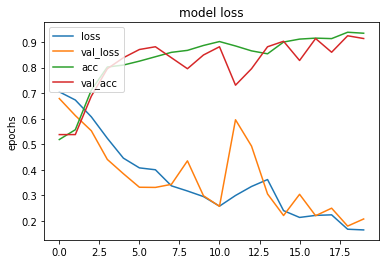

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylabel('epochs')
plt.legend(['loss', 'val_loss', 'acc' ,'val_acc'], loc='upper left')
plt.show()

In [16]:
print("정확도: {:.2f}%".format(model.evaluate(X_test, y_test)[1]* 100))

205/205 [==============================] - 0s 764us/step
정확도: 89.27%
